In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#point-based estimate
from scipy.optimize import curve_fit
from scipy.integrate import odeint

#interval-based estimate
import pystan
import arviz as az

from sklearn.metrics import r2_score

#animation
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = 'utils/ffmpeg'

In [2]:
def hill_activation(x, K, n, ymin):
    
    return ymin + (1 - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2):
    
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1) * hill_activation(x2, K2, n2, ymin2)

def gate_wrapper(t, r, y0, synGFP, degGFP, x1, x2, params):
    
    K1, K2, n1, n2, ymin1, ymin2 = params
    ymax = hill_activation_and((x1, x2), K1, K2, n1, n2, ymin1, ymin2)
    
    def gate_model(y, t):
        y1, GFP = y
        dy1 = r * (1 - (y1/ymax)) * y1
        print(ymax, y1)
        #dGFP = synGFP * y1 - degGFP * GFP
        dGFP = 0
        return [dy1, dGFP]
    
    solution = odeint(gate_model, [y0, 0], t)
    return solution.transpose()

In [3]:
def plot_trace(params, param_name='parameter', num_cols=2):
    
    num_rows = int(len(params)/num_cols)
    f, ax = plt.subplots(num_rows, num_cols*2, figsize=(7*num_cols, 2*num_rows))
    
    for i in tqdm(range(num_rows)):
        for j in range(num_cols):
            
            param = params[i*num_cols+j]
        
            mean = np.mean(param)
            median = np.median(param)
            cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

            ax[i, j*2].plot(param, label='chain-{}'.format(i*num_cols+j))
            ax[i, j*2].axhline(mean, color='r', lw=2, linestyle='--')
            ax[i, j*2].axhline(median, color='c', lw=2, linestyle='--')
            ax[i, j*2].axhline(cred_min, linestyle=':', color='k')
            ax[i, j*2].axhline(cred_max, linestyle=':', color='k')
            ax[i, j*2].legend(loc=1)

            ax[i, j*2+1].hist(param, 30, density=True);
            sns.kdeplot(param, shade=True, ax=ax[i, j*2+1])
            ax[i, j*2+1].axvline(mean, color='r', lw=2, linestyle='--', label='mean')
            ax[i, j*2+1].axvline(median, color='c', lw=2, linestyle='--', label='median')
            ax[i, j*2+1].axvline(cred_min, linestyle=':', color='k', label='95% CI')
            ax[i, j*2+1].axvline(cred_max, linestyle=':', color='k')
            ax[i, j*2+1].set_ylabel(None)
            ax[i, j*2+1].legend(loc=1)
    
    plt.suptitle(param_name)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

In [5]:
fluos = pd.read_csv('datasets/induction_matrix/induction_fluo.csv', index_col='time')
ods = pd.read_csv('datasets/induction_matrix/induction_od.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
cumas = [0, 6.25, 12.5, 25, 50, 100]
aras = [0, 0.8125, 3.25, 13, 52, 208]
x1, x2 = np.meshgrid(cumas, aras)
x = np.vstack((x1.ravel(), x2.ravel()))

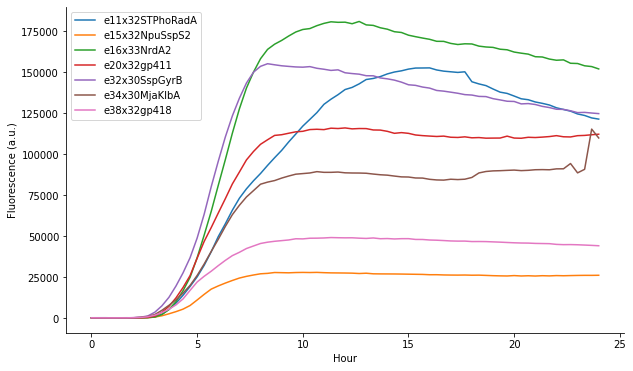

In [11]:
fig = plt.figure(figsize=[10, 6])
for gate in gates[:-2]:
    fluo = fluos['{}_55'.format(gate)]
    plt.plot(fluo.index/60, fluo, label=gate)
    plt.xlabel('Hour')
    plt.ylabel('Fluorescence (a.u.)')
plt.legend()
sns.despine()

### Hill Function

In [168]:
labels = ['K1', 'K2', 'n1', 'n2', 'ymin1', 'ymin2']
gate = 'e16x33NrdA2'
#t = 900

In [169]:
fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
y = fluo_t[t]
y[y < 0] = 0.01
y = y / y.max()

<ipython-input-169-c4c14ec2e93d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01


36it [00:00, 617.24it/s]


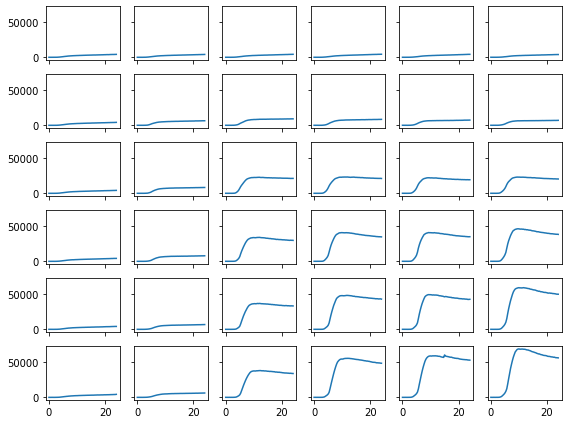

In [191]:
fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
#fluo.plot()
f, axs = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8, 6))
axr = axs.ravel()
for i, ax in tqdm(enumerate(axr)):
    if i < len(fluo):
        ax.plot(fluo.index/60, fluo.iloc[:, i])
    else:
        ax.set_visible(False)
plt.tight_layout()

In [170]:
loaded = az.from_netcdf('results/hill-combined-simplified/Hill-{}.nc'.format(gate, t))
thetas= []
for label in labels:
    thetas.append(np.array(loaded['posterior'][label]))
sigma = np.array(loaded['posterior']['sigma'])

100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


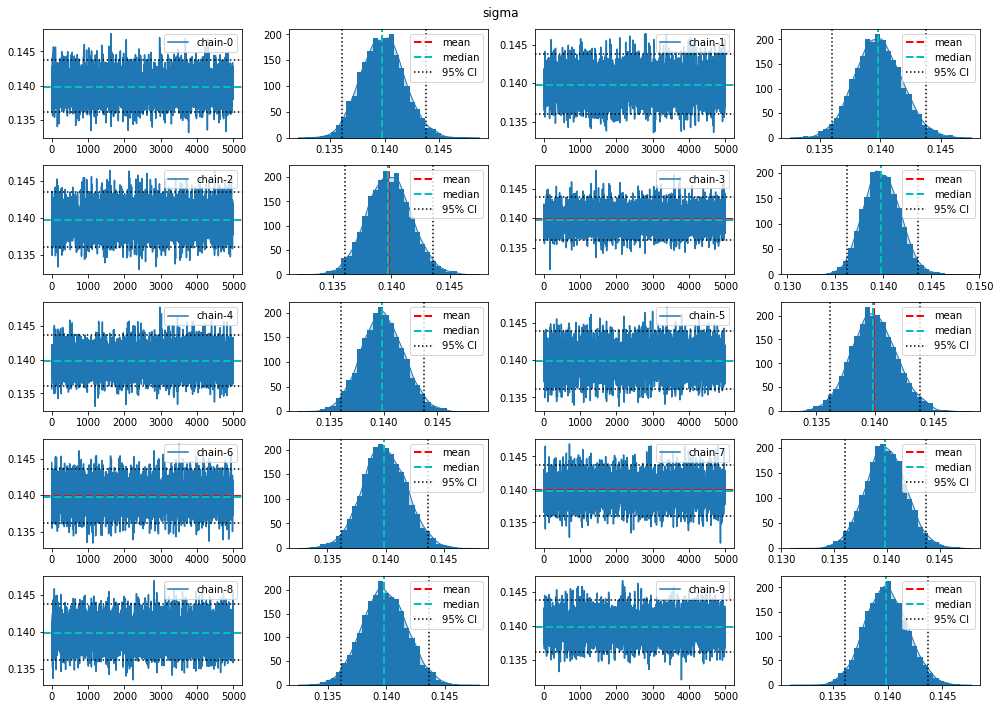

In [105]:
plot_trace(sigma, 'sigma')

100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


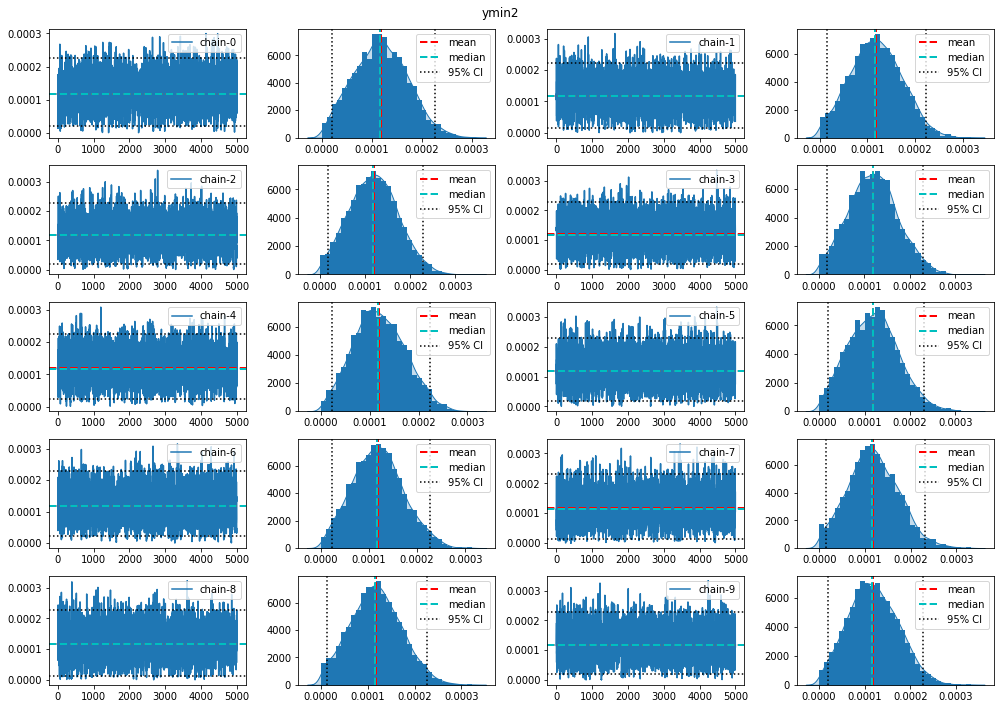

In [176]:
i = 5
plot_trace(thetas[i], labels[i])

<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y < 0] = 0.01
<ipython-input-184-91fc0ffa567e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

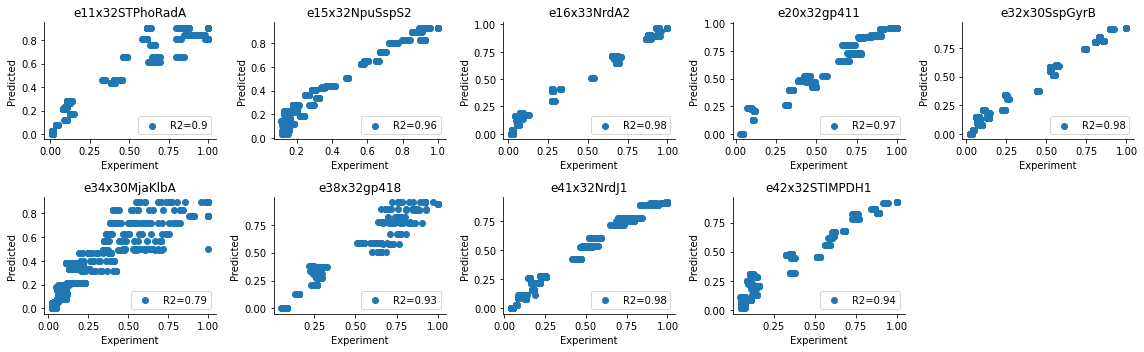

In [184]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        gate = gates[i]
        
        loaded = az.from_netcdf('results/hill-combined-simplified/Hill-{}.nc'.format(gate))
        thetas= []
        for label in labels:
            thetas.append(np.array(loaded['posterior'][label]))
            
        popt = [theta.mean() for theta in thetas]
        y_hat = hill_activation_and(x, *popt)
        
        fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
        fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
        
        real_data = []
        predicted_data = []
        for k in range(960, 1460, 20):
            y = fluo_t[k]
            y[y < 0] = 0.01
            y = y / y.max()
            real_data.append(y)
            predicted_data.append(y_hat)
        
        real_data = np.array(real_data)
        predicted_data = np.array(predicted_data)
        ax.scatter(real_data.ravel(), predicted_data.ravel(), label='R2={}'.format(round(r2_score(real_data.ravel(), predicted_data.ravel()), 2)))
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
        
    else:
        ax.set_visible(False)
    plt.tight_layout()
        

Simulating the parameters.

7 2588
0.943001511785254


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


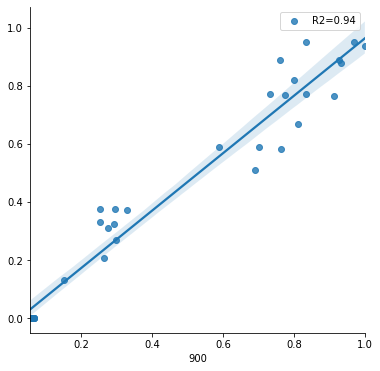

In [110]:
chain, idx = np.random.randint(0, 10), np.random.randint(0, 5000)
print(chain, idx)
popt = [theta[chain][idx] for theta in thetas]
y_hat = hill_activation_and(x, *popt)
print(r2_score(y, y_hat))
#print(np.corrcoef(y_std, y_hat)[0][1])
plt.figure(figsize=(6, 6))
sns.regplot(y, y_hat, label='R2={}'.format(np.round(r2_score(y, y_hat), 2)))
plt.legend()
sns.despine()

In [108]:
thetas_df = pd.DataFrame([t.ravel() for t in thetas]).T
thetas_df.columns = labels

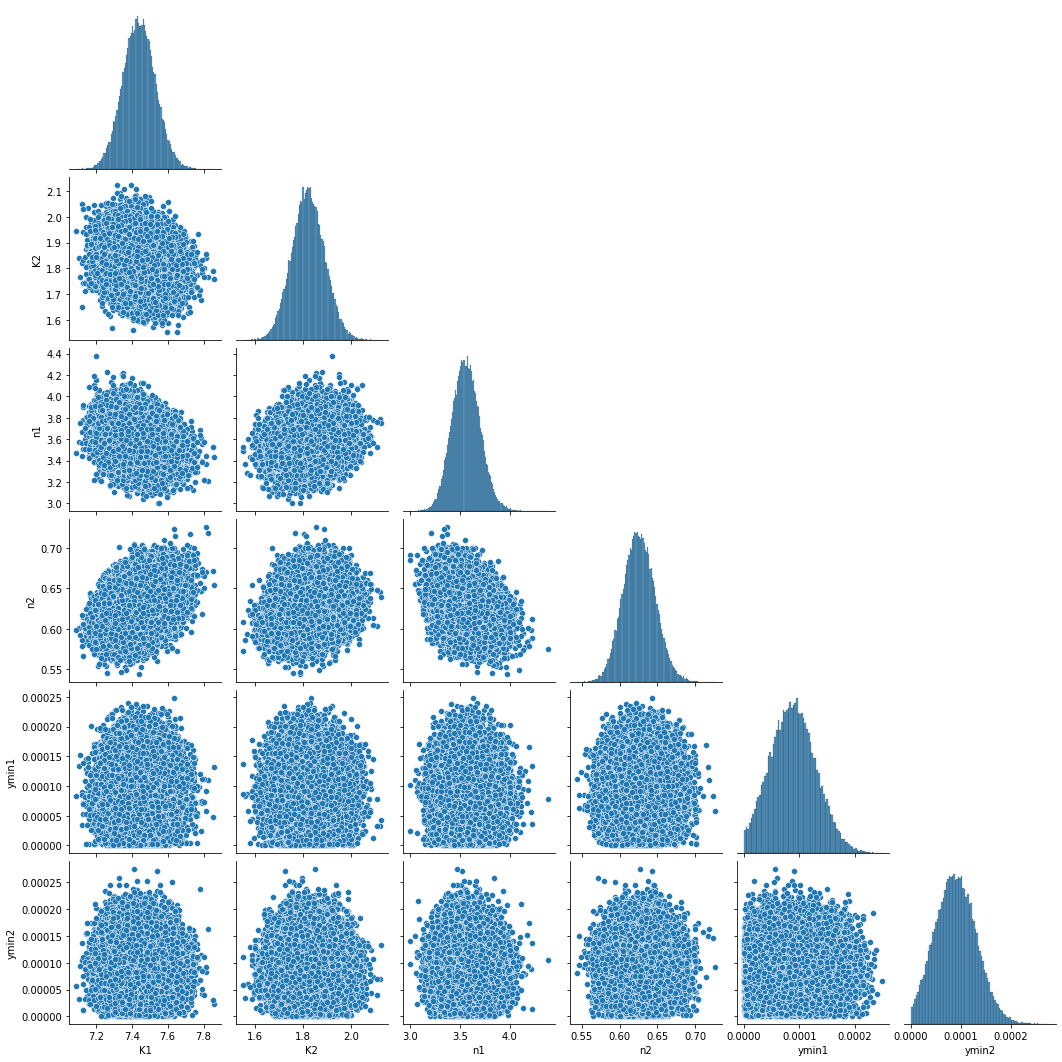

In [109]:
sns.pairplot(thetas_df, corner=True)
plt.show()

### Analysis

In [ ]:
all_r2s = []
for i, gate in tqdm(enumerate(gates)):
    
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    y = fluo_t[t]

    loaded = az.from_netcdf('results/hill/Hill-{}-{}.nc'.format(gate, t))
    thetas= []
    for label in labels:
        thetas.append(np.array(loaded['posterior'][label]))

    r2s = []
    for chain in tqdm(range(10)):
        for idx in range(5000):
            popt = [theta[chain][idx] for theta in thetas]
            y_hat = hill_activation_and(x, *popt)
            r2s.append(r2_score(y, y_hat))

    all_r2s.append(r2s)

In [ ]:
df_r2 = pd.DataFrame(np.array(all_r2s)).T
df_r2.columns = gates
sns.boxplot(data=df_r2.melt(), y='value', x='variable')
plt.ylim([0.90, 1.0])
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('R2')
sns.despine()

In [ ]:
max_r2 = [sorted(df_r2[gate].tolist())[-1] for gate in gates]
max_r2

In [ ]:
max_r2_loc = []
for i, gate in enumerate(gates):
    val = df_r2[gate].values.reshape(-1, 5000)
    max_r2_loc.append(np.where(val==max_r2[i]))
max_r2_loc

In [ ]:
f, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(9, 9))
axr = axs.ravel()
popts = []
for i, ax in tqdm(enumerate(axr)):
    
    if i < len(gates):
        gate = gates[i]

        fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
        fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
        y = fluo_t[t]

        loaded = az.from_netcdf('results/hill/Hill-{}-{}.nc'.format(gate, t))
        thetas= []
        for label in labels:
            thetas.append(np.array(loaded['posterior'][label]))

        popt = [theta[max_r2_loc[i][0][0]][max_r2_loc[i][1][0]] for theta in thetas]
        popts.append(popt)
        y_hat = hill_activation_and(x, *popt)

        sns.regplot(y, y_hat, label='R2={}'.format(np.round(r2_score(y, y_hat), 2)), ax=ax)
        ax.legend(loc=4)
        ax.set_title(gate)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

In [ ]:
hill_params = {}
for i, gate in enumerate(gates):
    hill_params[gate] = popts[i]

All parameters.

In [ ]:
all_pars = []
for i, gate in tqdm(enumerate(gates)):
    
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    y = fluo_t[t]

    loaded = az.from_netcdf('results/hill/Hill-{}-{}.nc'.format(gate, t))
    thetas= []
    for label in labels:
        thetas.append(np.array(loaded['posterior'][label]))

    pars = []
    for chain in tqdm(range(10)):
        for idx in range(5000):
            popt = [theta[chain][idx] for theta in thetas]
            #y_hat = hill_activation_and(x, *popt)
            #r2s.append(r2_score(y, y_hat))
            pars.append(popt)

    all_pars.append(pars)

In [ ]:
all_pars_T = np.array(all_pars).T

In [ ]:
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(16, 8))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(labels):
        
        temp = pd.DataFrame(all_pars_T[i], columns=gates)
        sns.boxplot(data=temp.melt(), y='value', x='variable', ax=ax)
        
        ax.set_xticklabels(gates, rotation=90)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(labels[i])
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

### Alternative Model

In [3]:
#at 24h
hill_params = {
    "e11x32STPhoRadA": [7.751379398582397, 4.427659927105025, 5.4364526386293885, 0.5873372443737356, 0.026357728242060084, 0.01680295581836571],
    "e15x32NpuSspS2": [9.122794964185752, 7.95126898918161, 2.854331030124338, 0.7428008115777417, 0.24225805748380314, 0.14529290120106214],
    "e16x33NrdA2": [9.456147610278604, 4.829003115276247, 3.399067788351665, 0.9180175290039748, 0.0001180466610213445, 0.0001183997017730263],
    "e20x32gp411": [13.340390925220001, 0.7078045598325073, 1.5821013105488064, 1.443781472312746, 8.381111440835662e-05, 8.35575134509024e-05],
    "e32x30SspGyrB": [10.143418377363817, 7.755006659481948, 2.556574923604361, 0.7818272930493256, 9.935990160905705e-05, 9.974411223699253e-05],
    "e34x30MjaKlbA": [9.001458206633695, 11.428446854909668, 1.0933867514229008, 1.0600646629268158, 0.00016400682274533759, 0.00016305640231122334],
    "e38x32gp418": [7.441303103850044, 1.82254638736088, 3.562038228871342, 0.6259695334275842, 8.884856612166981e-05, 8.980397657011261e-05],
    "e41x32NrdJ1": [8.336137834104784, 10.574983054205797, 3.1622513338731513, 0.7874701934257659, 8.136439049687377e-05, 8.067038881909733e-05],
    "e42x32STIMPDH1": [10.468086042894893, 5.539277314971308, 2.884542350419205, 0.6606769497813666, 0.10609810015533172, 0.10871273740946648]
}

In [6]:
gate = 'e11x32STPhoRadA'
a, b = 5, 5
cuma, ara = cumas[a], aras[b]
fluo = fluos['{}_{}{}'.format(gate, a, b)]

In [7]:
loaded = az.from_netcdf('results/alternative-combined-simplified/Alternative-{}-{}{}.nc'.format(gate, a, b))
num_params = np.array(loaded['posterior']['theta']).shape[2]
thetas = []
for i in range(num_params):
    thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])
y0 = np.array(loaded['posterior']['y0'])
sigma = np.array(loaded['posterior']['sigma'])

100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


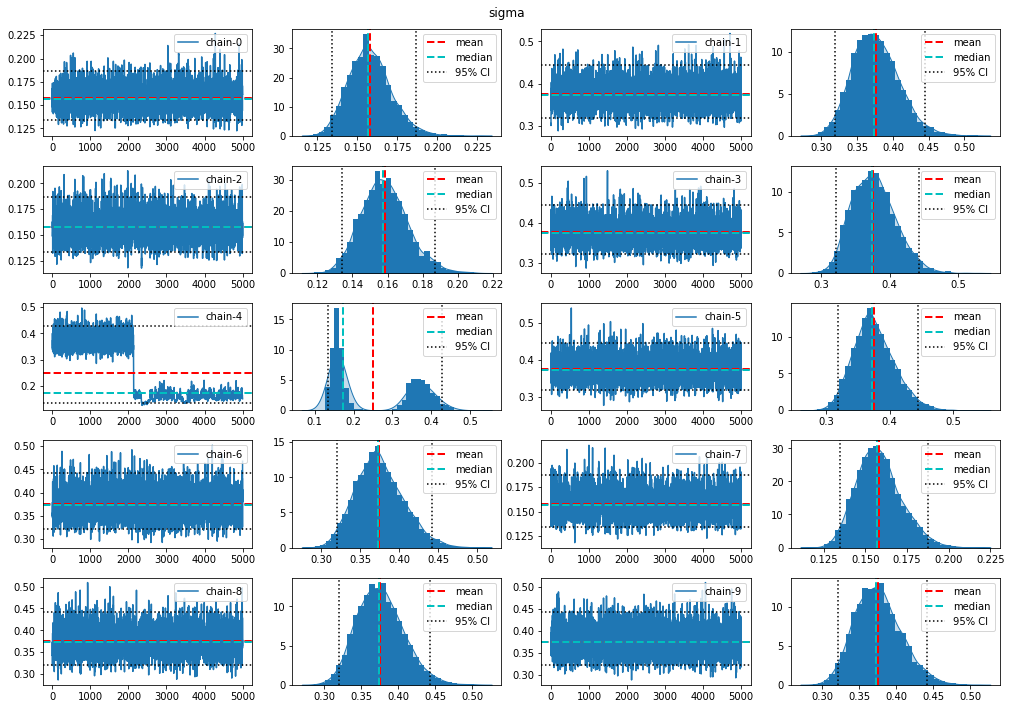

In [156]:
plot_trace(sigma, 'sigma')

100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


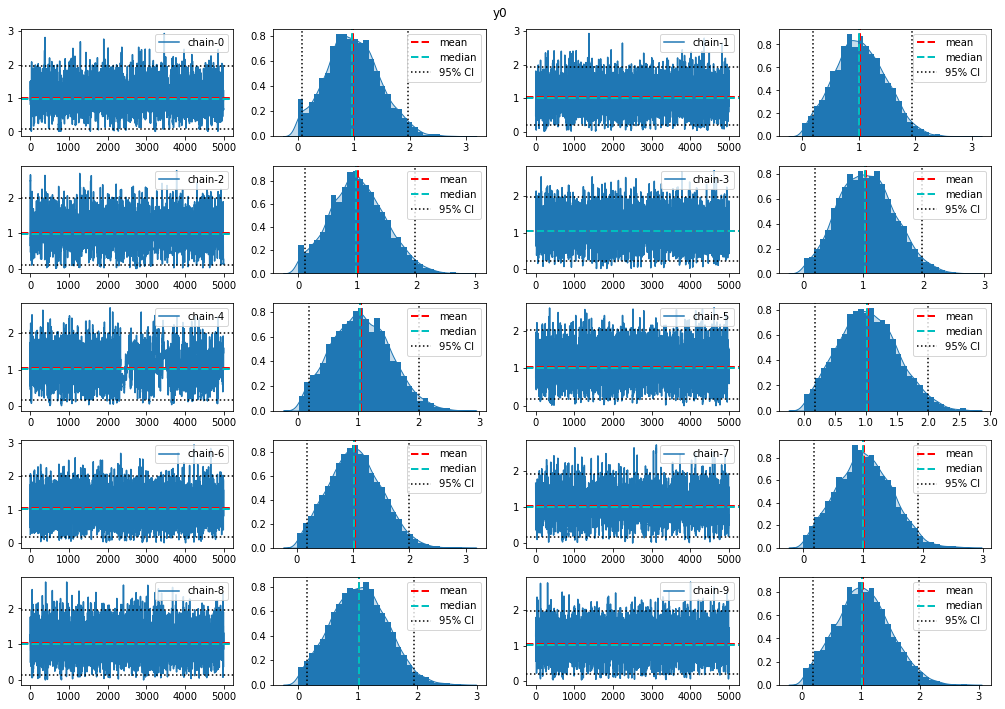

In [157]:
plot_trace(y0, 'y0')

100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


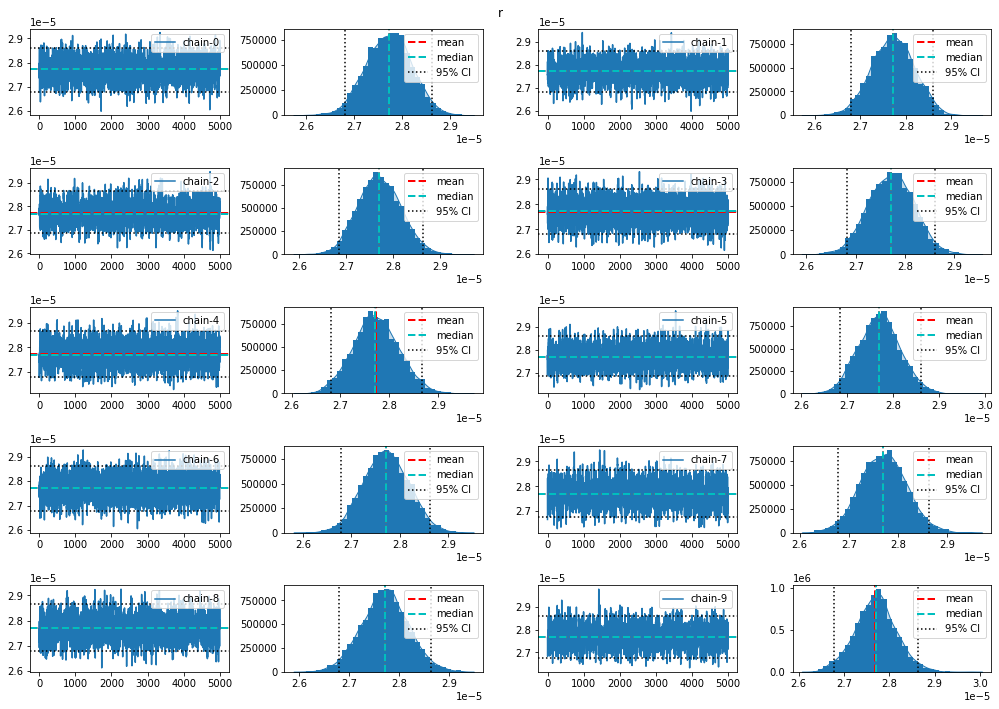

In [144]:
plot_trace(thetas[0], 'r')

100%|██████████| 5/5 [00:01<00:00,  3.98it/s]


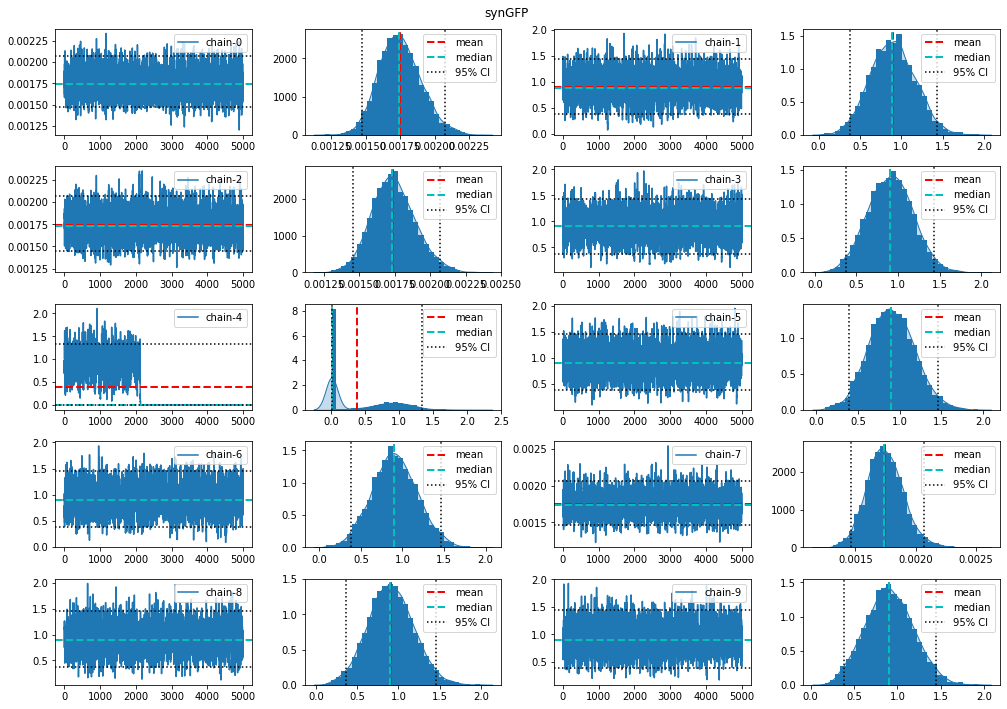

In [160]:
plot_trace(thetas[1], 'synGFP')

100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


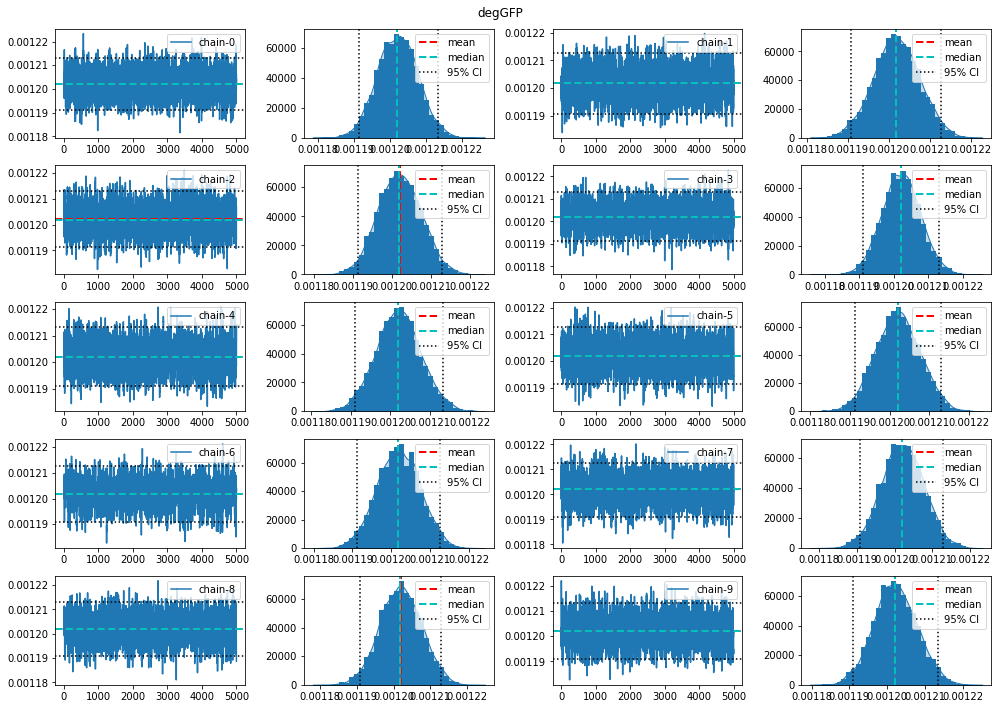

In [146]:
plot_trace(thetas[2], 'degGFP')

Simulating the parameters.

In [163]:
popt

[1.07923522737875, 0.8235463160584371, 0.0017970032751334912, 0.01]

0.9071850613083821 1.7823170647011104
0.9071850613083821 1.7819783539772118
0.9071850613083821 1.7819785494151872
0.9071850613083821 1.782133158156183
0.9071850613083821 1.7821332157758485
0.9071850613083821 1.7819493668144835
0.9071850613083821 1.7819494244081382
0.9071850613083821 1.7815819568059257
0.9071850613083821 1.781581956745974
0.9071850613083821 1.7812147192844776
0.9071850613083821 1.7812147191805658
0.9071850613083821 1.7808477115900354
0.9071850613083821 1.7808477114862542
0.9071850613083821 1.777190237163603
0.9071850613083821 1.7771902330547977
0.9071850613083821 1.7735555091273358
0.9071850613083821 1.7735555143732924
0.9071850613083821 1.7699433516400287
0.9071850613083821 1.7699433526549118
0.9071850613083821 1.7663535457998314
0.9071850613083821 1.7663535468015414
0.9071850613083821 1.7445530229454007
0.9071850613083821 1.7445531322193322
0.9071850613083821 1.7235616130631046
0.9071850613083821 1.723561512490527
0.9071850613083821 1.7033364936091193
0.90718506130838

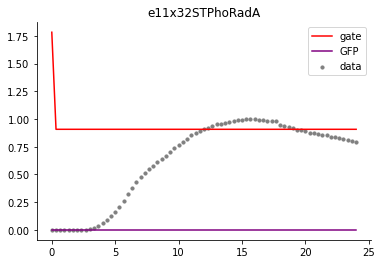

In [159]:
chain, idx = 8, 2999
popt = [thetas[0][chain][idx], np.array(loaded['posterior']['y0'])[chain][idx], thetas[1][chain][idx], thetas[2][chain][idx]]
sim = gate_wrapper(fluo.index, *popt, cuma, ara, hill_params[gate])
plt.plot(fluo.index/60, sim[0], color='red', label='gate')
plt.plot(fluo.index/60, sim[1], color='purple', label='GFP')
plt.scatter(fluo.index/60, fluo/fluo.max(), color='gray', label='data', s=10)
plt.title(gate)
plt.legend()
sns.despine()

0.0004428877431238257 0.8235463160584371
0.0004428877431238257 0.8233237149002642
0.0004428877431238257 0.8233238352527091
0.0004428877431238257 0.8234216294357681
0.0004428877431238257 0.8234216671986934
0.0004428877431238257 0.8232970183160773
0.0004428877431238257 0.8232970560618573
0.0004428877431238257 0.823047909245472
0.0004428877431238257 0.8230479092054936
0.0004428877431238257 0.8227989132180543
0.0004428877431238257 0.8227989131495639
0.0004428877431238257 0.8225500678141952
0.0004428877431238257 0.822550067745791
0.0004428877431238257 0.8200698730206706
0.0004428877431238257 0.8200698703138569
0.0004428877431238257 0.8176045847851009
0.0004428877431238257 0.817604588246791
0.0004428877431238257 0.8151540872291494
0.0004428877431238257 0.8151540879028922
0.0004428877431238257 0.8127182360976576
0.0004428877431238257 0.8127182367625408
0.0004428877431238257 0.7979897105323087
0.0004428877431238257 0.7979897819407087
0.0004428877431238257 0.78378584564955
0.0004428877431238257

0.43259382987182976 0.5236939444172514
0.43259382987182976 0.5236938901716002
0.43259382987182976 0.5174239986242596
0.43259382987182976 0.5174239596208845
0.43259382987182976 0.5116507268969442
0.43259382987182976 0.511650698124891
0.43259382987182976 0.5063263576016088
0.43259382987182976 0.506326335292287
0.43259382987182976 0.49995214000854604
0.43259382987182976 0.4999520956811959
0.43259382987182976 0.4941960599187274
0.43259382987182976 0.4941959595381027
0.43259382987182976 0.48898726943728577
0.43259382987182976 0.4889872043734596
0.43259382987182976 0.48426497504054244
0.43259382987182976 0.48426492324242004
0.43259382987182976 0.47997643265341755
0.43259382987182976 0.47997639539203485
0.43259382987182976 0.4760757871331835
0.43259382987182976 0.4760757601480021
0.43259382987182976 0.4725229675675797
0.43259382987182976 0.47252294663167044
0.43259382987182976 0.46830623560735823
0.43259382987182976 0.4683061934233716
0.43259382987182976 0.46456498185461165
0.4325938298718297

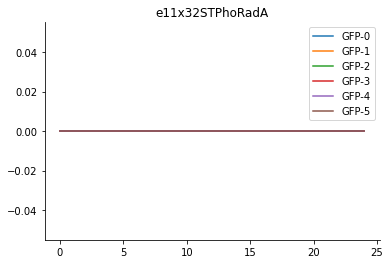

In [162]:
chain, idx = 0, 1000
popt = [thetas[0][chain][idx], np.array(loaded['posterior']['y0'])[chain][idx], thetas[1][chain][idx], 0.01]
for i in range(6):
    sim = gate_wrapper(fluo.index, *popt, cumas[i], aras[i], hill_params[gate])
    #plt.plot(fluo.index/60, sim[0], color='red', label='gate')
    plt.plot(fluo.index/60, sim[1], label='GFP-{}'.format(i))
plt.title(gate)
plt.legend()
sns.despine()

In [12]:
thetas.append(y0)
np.array(thetas).shape

(4, 10, 5000)

In [17]:
thetas_df = pd.DataFrame([t[6:9].ravel() for t in thetas]).T
thetas_df.columns = ['r', 'synGFP', 'degGFP', 'y0']
thetas_df

,r,synGFP,degGFP,y0
0,0.013510,0.010927,0.012733,1036.868717
1,0.013510,0.010891,0.012687,1040.148400
2,0.013580,0.010766,0.012548,1032.597776
3,0.013607,0.010834,0.012627,1015.307663
4,0.013602,0.010827,0.012620,1008.628404
...,...,...,...,...
14995,0.013546,0.010962,0.012778,1025.740999
14996,0.013427,0.011108,0.012947,1058.868456
14997,0.013503,0.011080,0.012923,1028.564376
14998,0.013554,0.011127,0.012961,1004.481242


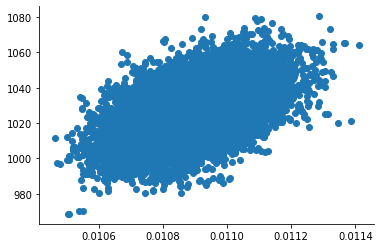

In [21]:
plt.scatter(thetas_df['synGFP'], thetas_df['y0'])
sns.despine()

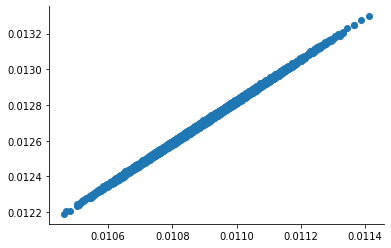

In [22]:
plt.scatter(thetas_df['synGFP'], thetas_df['degGFP'])
sns.despine()

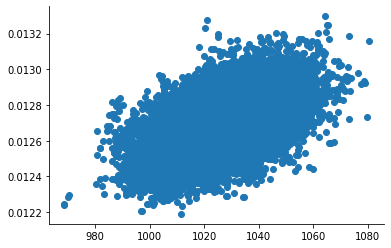

In [23]:
plt.scatter(thetas_df['y0'], thetas_df['degGFP'])
sns.despine()

In [ ]:
#for k in range(1, 6):
popt2 = [0.057398876924417692, 0.01, 0.01421476598994333*5, 0.01]
sim = gate_wrapper(fluo.index, *popt2, cuma, ara, hill_params[gate])
plt.plot(fluo.index/60, sim[0], label='gate-{}'.format(k))
plt.plot(fluo.index/60, sim[1], label='GFP-{}'.format(k))
plt.scatter(fluo.index/60, fluo, color='gray', label='data', s=10)
plt.legend()
sns.despine()

### Fitting Result

In [ ]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in tqdm(enumerate(axr)):
    if i < len(gates):
        gate = gates[i]
        
        a, b = 5, 5
        cuma, ara = cumas[a], aras[b]
        fluo = fluos['{}_{}{}'.format(gate, a, b)]
        
        loaded = az.from_netcdf('results/alternative/P3-Alternative-{}-{}{}.nc'.format(gate, a, b))
        num_params = np.array(loaded['posterior']['theta']).shape[2]
        thetas= []
        for i in range(num_params):
            thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])
        thetas.append(np.array(loaded['posterior']['y0']))
        
        #chain, idx = np.random.randint(10), np.random.randint(5000)
        popt = [np.mean(thetas[0]), np.mean(thetas[2]), np.mean(thetas[1]), 0.01]
        sim = gate_wrapper(fluo.index, *popt, cuma, ara, hill_params[gate])
        ax.plot(fluo.index/60, sim[0], color='red', label='gate')
        ax.plot(fluo.index/60, sim[1], color='purple', label='GFP')
        ax.scatter(fluo.index/60, fluo, color='gray', label='data', s=10)
        ax.set_title(gate)
        ax.legend()
        sns.despine()
        
    else:
        ax.set_visible(False)
        
plt.tight_layout()

### Analysis

In [ ]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
popts = []
for i, ax in tqdm(enumerate(axr)):
    if i < len(gates):
        gate = gates[i]
        popt = []
        for j in range(6):
            cuma, ara = cumas[j], aras[j]
            fluo = fluos['{}_{}{}'.format(gate, j, j)]
            loaded = az.from_netcdf('results/alternative/P3-Alternative-{}-{}{}.nc'.format(gate, j, j))
            num_params = np.array(loaded['posterior']['theta']).shape[2]
            thetas= []
            for i in range(num_params):
                thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])
            thetas.append(np.array(loaded['posterior']['y0']))
            popt.append([np.mean(thetas[0]), np.mean(thetas[2]), np.mean(thetas[1]), 0.01])
        popts.append(popt)

In [ ]:
gate_params = pd.DataFrame()
for i in range(len(gates)):
    temp = pd.DataFrame(popts[i], columns=['r', 'y0', 'synGFP', 'degGFP'])
    temp['gate'] = gates[i]
    gate_params = gate_params.append(temp)

In [ ]:
pars = ['r', 'y0', 'synGFP', 'degGFP']
f, axs = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(16, 4))
ax = axs.ravel()
for i, p in enumerate(pars):
    sns.boxplot(data=gate_params[['gate', p]], x='gate', y=p, showfliers=False, ax=ax[i])
    ax[i].set_xticklabels(gates, rotation=90)
    sns.despine()
plt.tight_layout()

In [ ]:
gate_params.groupby('gate').median()

### Animation

In [ ]:
%matplotlib inline
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = 'utils/ffmpeg'

fig, ax = plt.subplots(figsize=(16, 6))
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

anim = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)
#plt.close()
FFwriter = FFMpegWriter()
anim.save('datasets/basic_animation.mp4', writer=FFwriter)

In [ ]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
anim.save('datasets/test.gif', writer='imagemagick')
plt.show()